In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import seaborn as sns

logging.basicConfig(level=logging.INFO)
sns.set_style("white")
sns.set_context("talk")
np.random.seed(0)

/Users/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


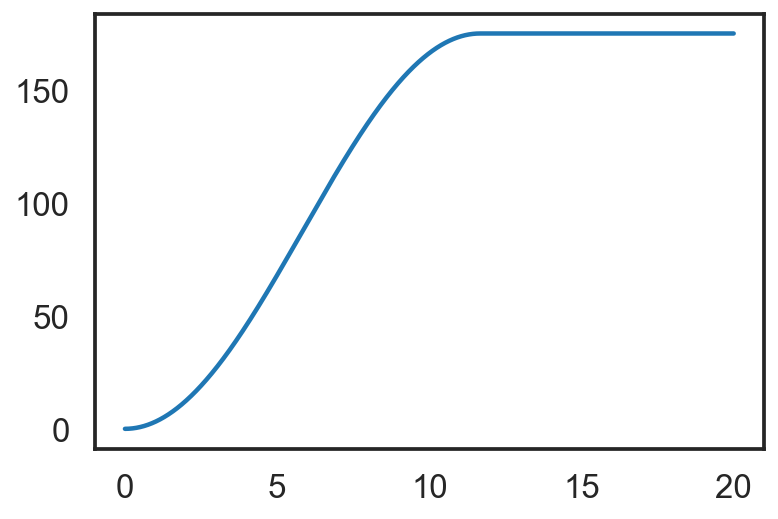

In [3]:
from replay_trajectory_classification.simulate import (
    simulate_multiunit_with_place_fields, simulate_time, simulate_linear_distance_with_pauses)

time_duration = 20
sampling_frequency = 1000
track_height = 175
pause_duration = 1.0

time = simulate_time(
    sampling_frequency * time_duration, sampling_frequency)
position = simulate_linear_distance_with_pauses(
    time, track_height, sampling_frequency=sampling_frequency,
    pause=pause_duration)


place_field_means = np.stack((np.arange(0, 200, 50),
                              np.arange(25, 200, 50),
                              np.arange(12.5, 200, 50),
                             ))
# place_field_means = np.concatenate([place_field_means for _ in range(10)], axis=0)


multiunits = np.stack([
    simulate_multiunit_with_place_fields(means, position,
                                         sampling_frequency=sampling_frequency)
    for means in place_field_means], axis=-1)

plt.plot(time, position)

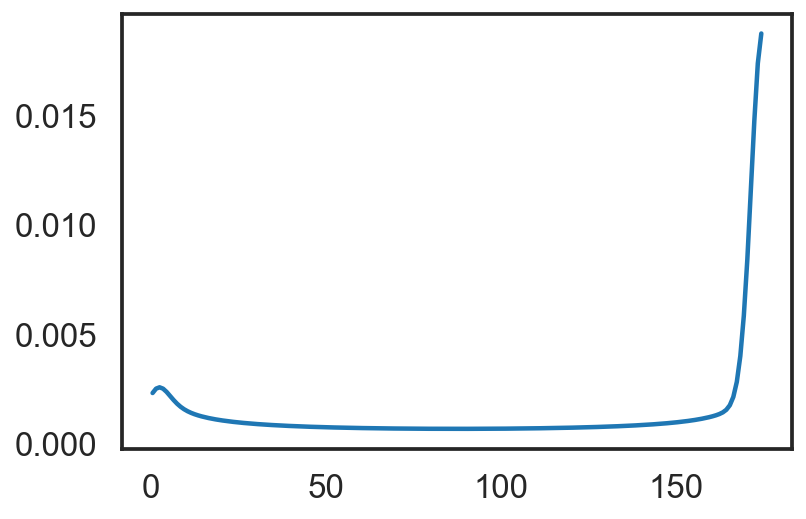

In [4]:
from replay_trajectory_classification.multiunit_likelihood_numba import product_kde2
from replay_trajectory_classification.core import get_grid

place_bin_size = 1.0

(edges_, place_bin_edges_, place_bin_centers_,
 centers_shape_) = get_grid(
    position, place_bin_size, None,
    False)

bandwidths = np.array([np.sqrt(10)])
occupancy = product_kde2(place_bin_centers_, position[:, np.newaxis], bandwidths)

plt.plot(place_bin_centers_, occupancy)

In [5]:
multiunit_spikes = np.any(~np.isnan(multiunits), axis=1)
mean_rates = multiunit_spikes.mean(axis=0)

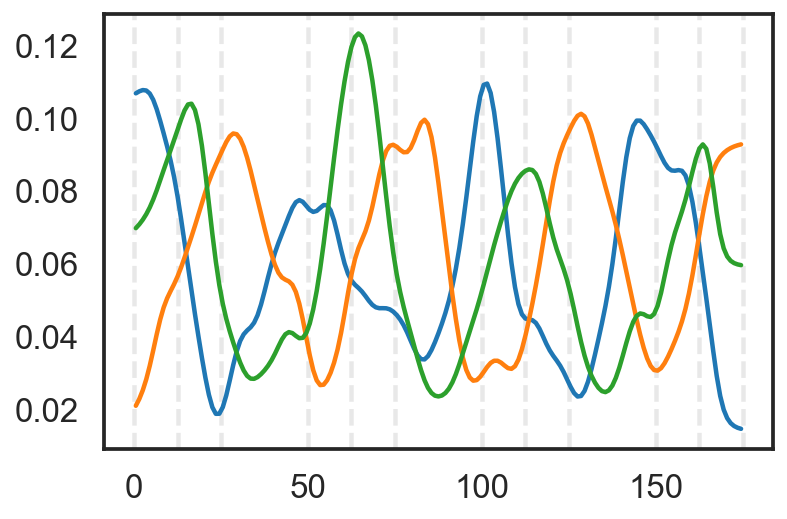

In [6]:

bandwidths = np.array([np.sqrt(10)])

ground_intensity = [mean_rate * product_kde2(place_bin_centers_, position[is_spike, np.newaxis], bandwidths) / occupancy
                    for is_spike, mean_rate in zip(multiunit_spikes.T, mean_rates)]

for gpi, means in zip(ground_intensity, place_field_means):
    plt.plot(place_bin_centers_, gpi)
    for mean in means:
        plt.axvline(mean, zorder=0, linestyle='--', alpha=0.5, color='lightgrey')

In [7]:
training_marks = [multiunits[is_spike, :, tetrode_ind] for tetrode_ind, is_spike in enumerate(multiunit_spikes.T)]
training_position = [position[is_spike, np.newaxis] for tetrode_ind, is_spike in enumerate(multiunit_spikes.T)]

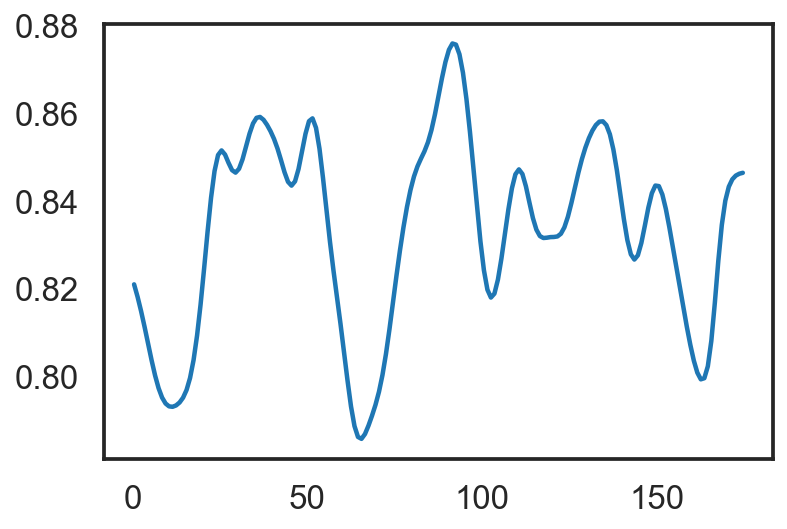

In [8]:
from replay_trajectory_classification.multiunit_likelihood_numba import get_log_likelihood

l = get_log_likelihood(
    multiunits[52:54], place_bin_centers_, occupancy,
    ground_intensity, training_marks, training_position, mean_rates, place_bandwidth=2.0, mark_bandwidth=20.0)
plt.plot(place_bin_centers_, np.exp(l[0]))

In [9]:
# %%timeit

# get_log_likelihood(
#     multiunits, place_bin_centers_, occupancy,
#     ground_intensity, training_marks, training_position, mean_rates,
#     place_bandwidth=np.sqrt(10), mark_bandwidth=1.0)


In [10]:
l = get_log_likelihood(
    multiunits, place_bin_centers_, occupancy,
    ground_intensity, training_marks, training_position, mean_rates,
    place_bandwidth=np.sqrt(10), mark_bandwidth=1.0)

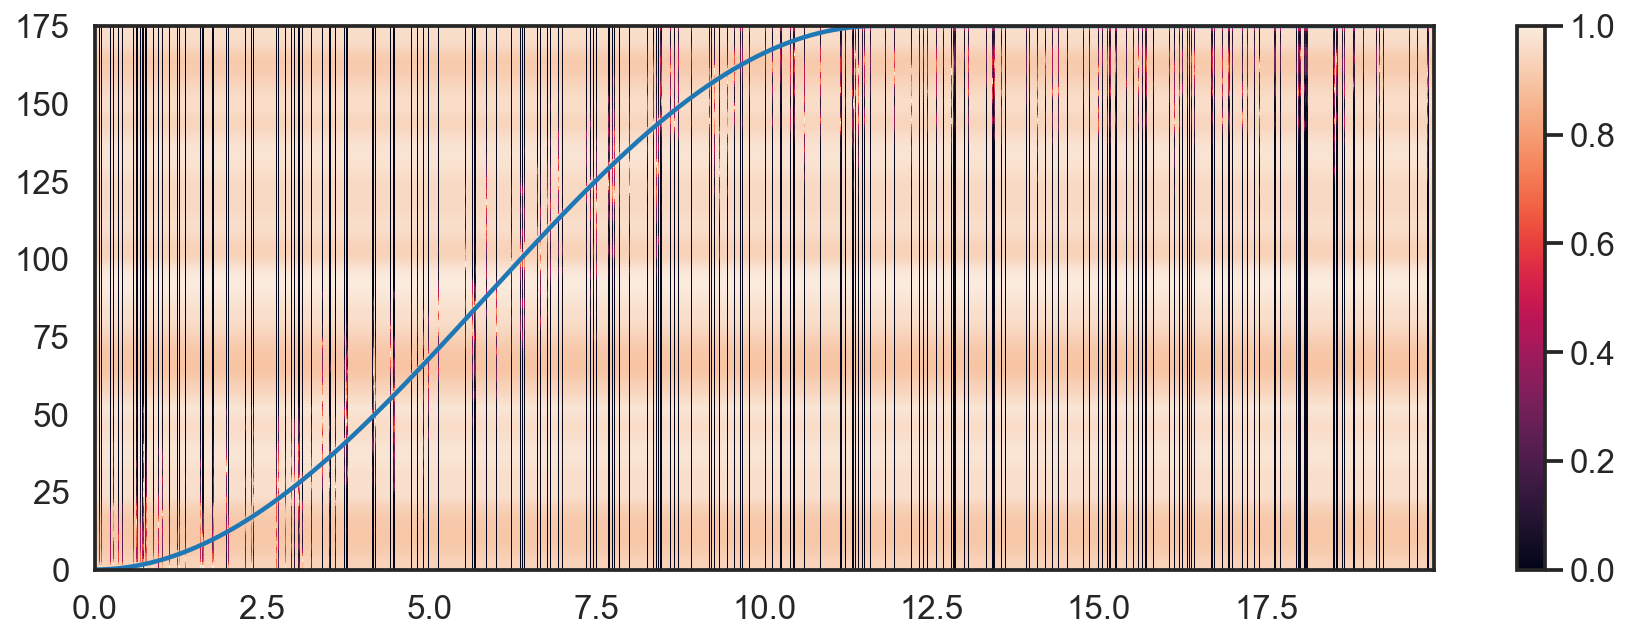

In [11]:
from replay_trajectory_classification.multiunit_likelihood import scaled_likelihood

t, x = np.meshgrid(time, place_bin_centers_)

plt.figure(figsize=(15, 5))
plt.pcolormesh(t, x, scaled_likelihood(l).T)
plt.plot(time, position)
plt.ylim((0, track_height))
plt.colorbar()

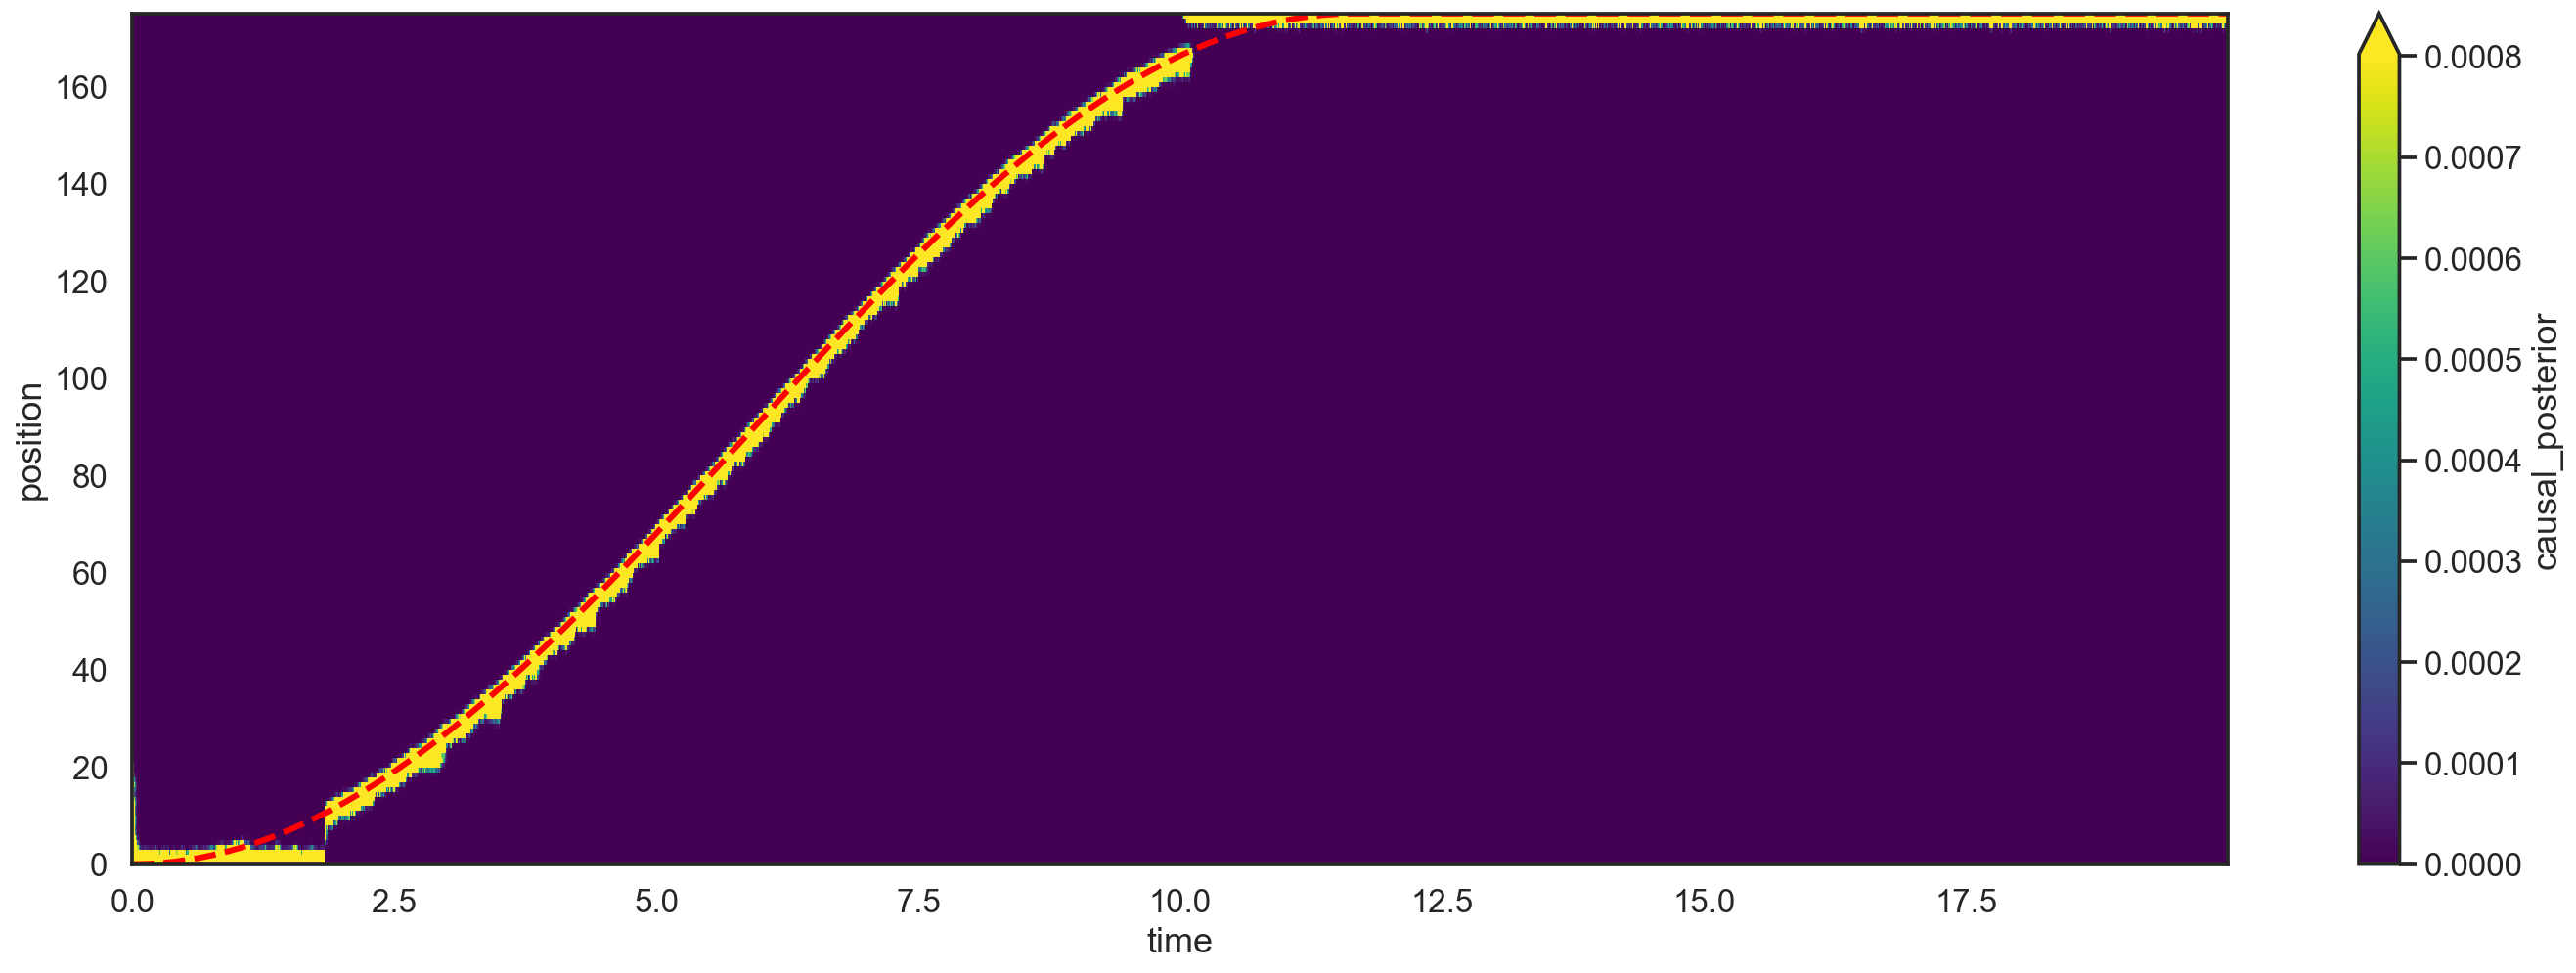

In [12]:
import xarray as xr
from replay_trajectory_classification.core import _causal_decode, get_centers
from replay_trajectory_classification.initial_conditions import uniform
from replay_trajectory_classification.state_transition import random_walk, estimate_movement_var

initial_conditions = uniform(place_bin_centers_)
movement_var = estimate_movement_var(position, sampling_frequency)
is_track_interior = np.ones((place_bin_centers_.shape[0],), dtype=bool)
state_transition = random_walk(place_bin_centers_, movement_var, is_track_interior,
                replay_speed=1)

results = dict()
results['causal_posterior'] = _causal_decode(initial_conditions, state_transition, scaled_likelihood(l))
results['likelihood'] = scaled_likelihood(l)


n_position_dims = place_bin_centers_.shape[1]
if n_position_dims > 1:
    new_shape = (n_time, *centers_shape_)
    dims = ['time', 'x_position', 'y_position']
    coords = dict(
        time=time,
        x_position=get_centers(edges_[0]),
        y_position=get_centers(edges_[1]),
    )
    results = xr.Dataset(
        {key: (dims, value.reshape(new_shape).swapaxes(-1, -2))
         for key, value in results.items()},
        coords=coords)
else:
    dims = ['time', 'position']
    coords = dict(
        time=time,
        position=get_centers(edges_[0]),
    )
    results = xr.Dataset(
        {key: (dims, value)
         for key, value in results.items()},
        coords=coords)

results.causal_posterior.plot(x='time', y='position', robust=True, size=8, aspect=3)
plt.plot(time, position, linewidth=3, linestyle='--', color='red')

In [13]:
import hvplot.xarray

(results.causal_posterior.hvplot(groupby='time', width=250, ylim=((0, 1))) + 
 results.likelihood.hvplot(groupby='time', width=250, ylim=((0, 1))))

:Layout
   .DynamicMap.I  :DynamicMap   [time]
      :Curve   [position]   (causal_posterior)
   .DynamicMap.II :DynamicMap   [time]
      :Curve   [position]   (likelihood)

In [5]:
from replay_trajectory_classification.decoder import ClusterlessDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var = estimate_movement_var(position, sampling_frequency)

decoder = ClusterlessDecoder(replay_speed=1, movement_var=movement_var,
                             infer_track_interior=False,
                             initial_conditions_type='uniform',
                             transition_type='random_walk',
                             place_bin_size=1.0).fit(position, multiunits)
results2 = decoder.predict(multiunits, time=time, is_compute_acausal=False)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting multiunits...


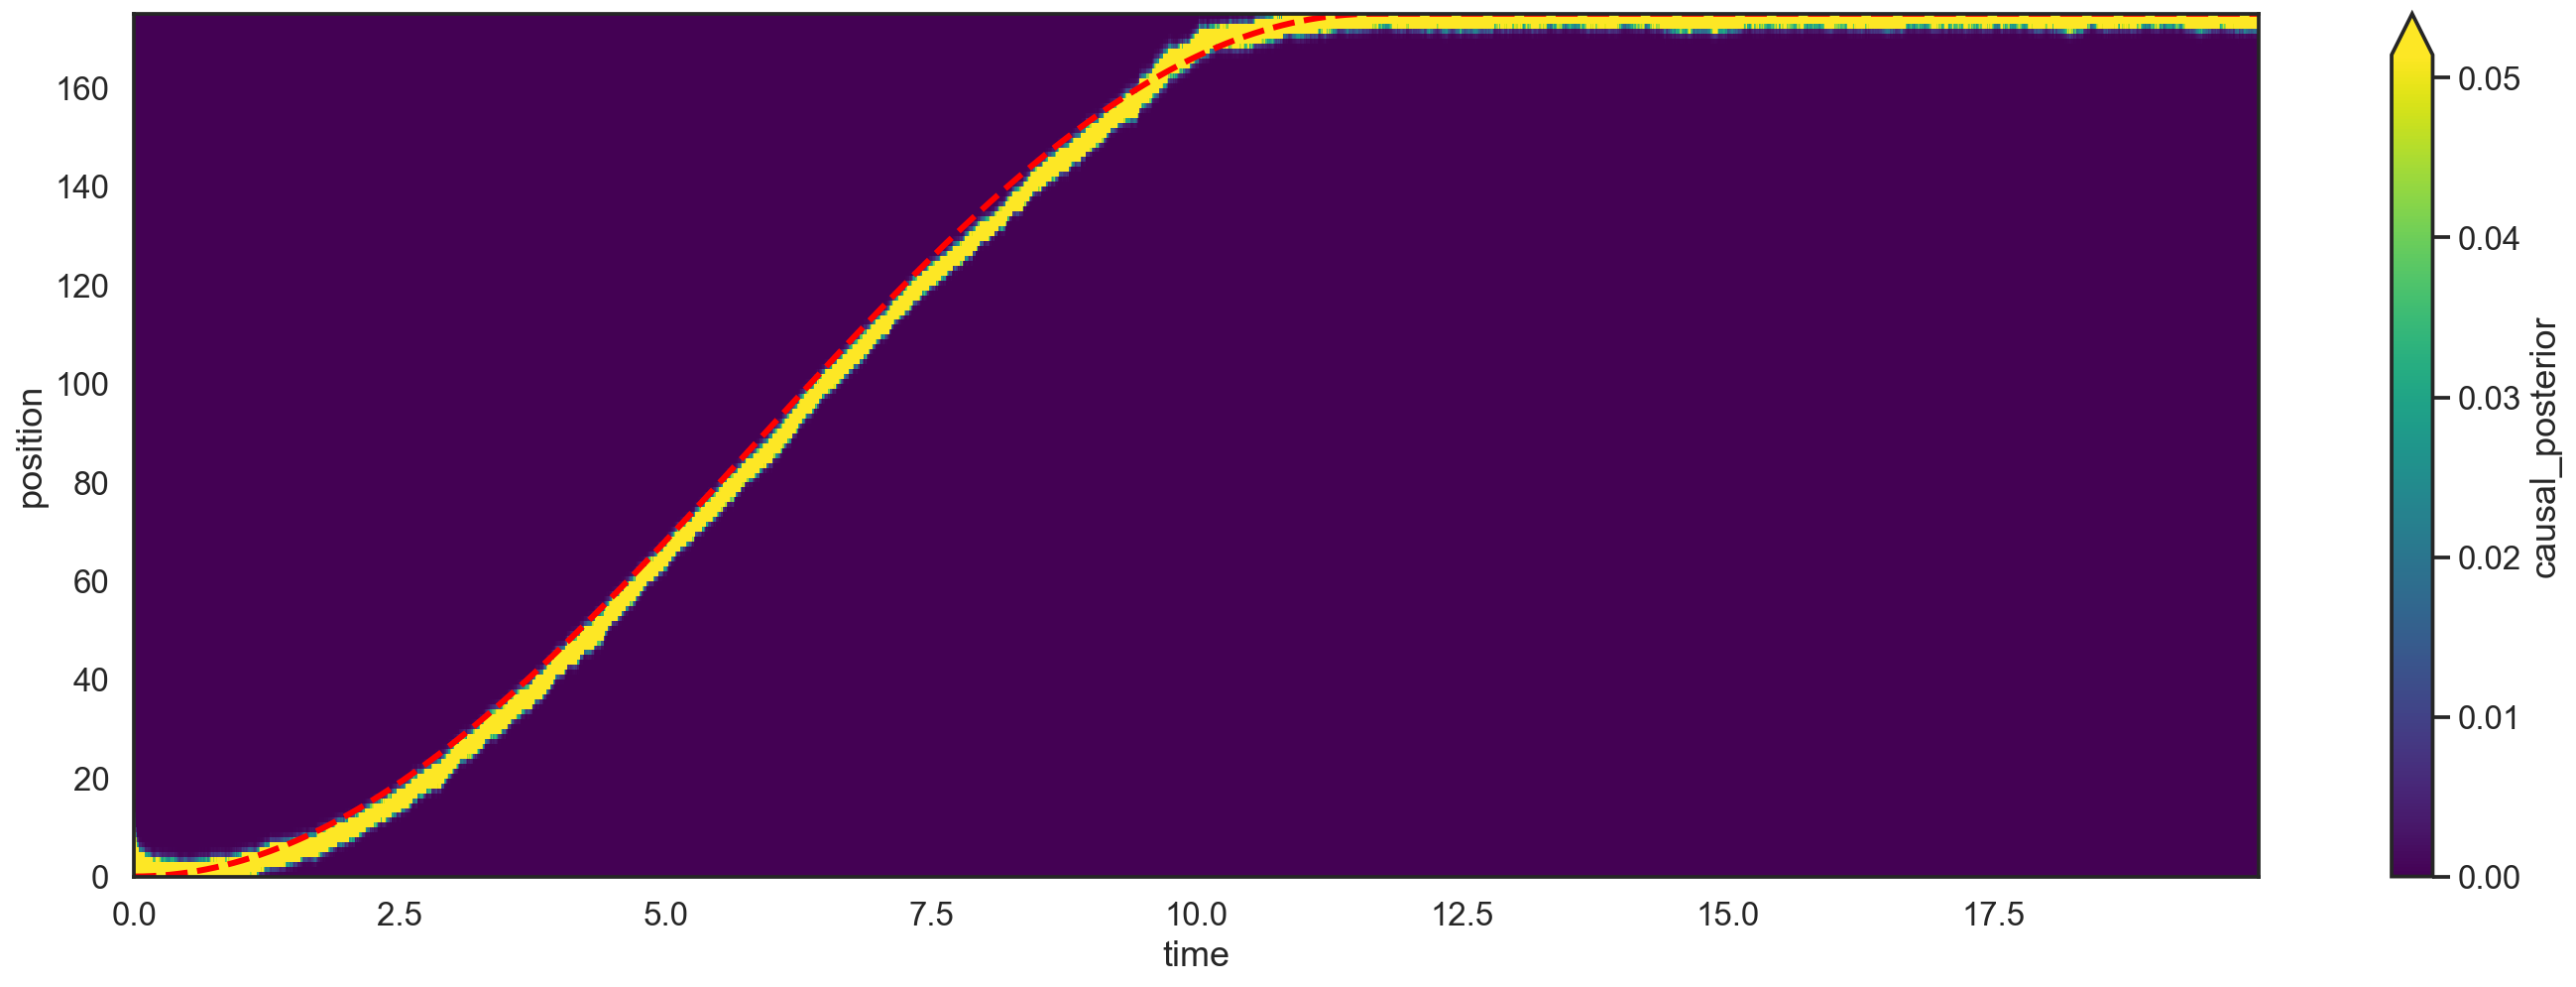

In [18]:
results2.causal_posterior.plot(x='time', y='position', robust=True, size=8, aspect=3)
plt.plot(time, position, linewidth=3, linestyle='--', color='red')

In [ ]:
import hvplot.xarray

(results2.causal_posterior.hvplot(groupby='time', width=250, ylim=((0, 1))) + 
 results2.likelihood.hvplot(groupby='time', width=250, ylim=((0, 1))))

In [ ]:
get_log_likelihood.parallel_diagnostics()

In [ ]:
get_log_likelihood.inspect_types()

In [22]:
from dask.distributed import Client

client = Client(processes=True)

decoder = ClusterlessDecoder(replay_speed=1, movement_var=movement_var,
                             infer_track_interior=False,
                             initial_conditions_type='uniform',
                             transition_type='random_walk',
                             place_bin_size=1.0).fit(position, multiunits)

/Users/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)
INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting multiunits...


In [27]:
%%timeit

decoder.predict(multiunits, time=time, is_compute_acausal=False)

3.03 s ± 76.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
def get_place_field_max(classifier):
    try:
        max_ind = classifier.place_fields_.argmax('position')
        return np.asarray(
            classifier.place_fields_.position[max_ind].values.tolist())
    except AttributeError:
        return np.asarray(
            [classifier.place_bin_centers_[gpi.result().argmax()]
             for gpi in classifier.ground_process_intensities_])
        
get_place_field_max(decoder)

array([[  0.5],
       [174.5],
       [  0.5]])

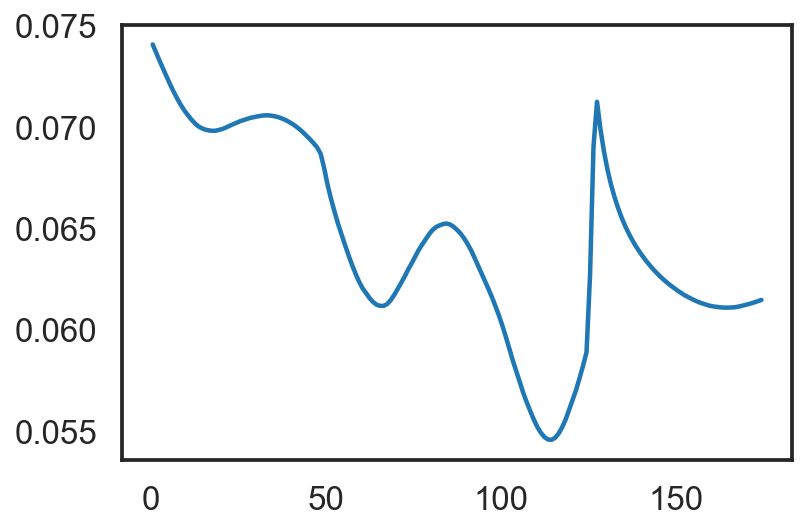

In [23]:
plt.plot(decoder.place_bin_centers_, decoder.ground_process_intensities_[2].result().squeeze())